<a href="https://colab.research.google.com/github/baroneleonardo/NO2-Virtual-Sensor/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

!pip install keras.tuner
from kerastuner.tuners import RandomSearch

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.3 MB/s eta 0:00:00


<ipython-input-2-537dbb9cc2b2>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Mounted at /content/drive


In [40]:
data = pd.read_csv("/content/drive/MyDrive/data_dausare.csv")
data = data.set_index('Datetime')
data.describe()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.707856,939.029205,835.370973,113.075515,1022.780725,18.316054,49.232360,1.025530
std,217.084571,266.829000,256.815106,48.359250,398.480897,8.832888,17.316389,0.403813
min,647.250000,383.250000,322.000000,2.000000,221.000000,-1.900000,9.175000,0.184679
25%,936.750000,734.375000,657.875000,78.000000,731.375000,11.787500,35.812500,0.736769
50%,1063.000000,909.000000,805.500000,109.000000,963.250000,17.750000,49.550000,0.995395
75%,1231.250000,1116.250000,969.250000,142.000000,1273.375000,24.400000,62.500001,1.313701
max,2039.750000,2214.000000,2682.750000,339.700000,2522.750000,44.600000,88.725000,2.231036


In [41]:
data = data.dropna(subset=["NO2(GT)"])
data = data.dropna(subset=["T"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7393 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7393 non-null   float64
 1   PT08.S2(NMHC)  7393 non-null   float64
 2   PT08.S3(NOx)   7393 non-null   float64
 3   NO2(GT)        7393 non-null   float64
 4   PT08.S5(O3)    7393 non-null   float64
 5   T              7393 non-null   float64
 6   RH             7393 non-null   float64
 7   AH             7393 non-null   float64
dtypes: float64(8)
memory usage: 519.8+ KB


In [42]:
warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU')
print(tf.__version__)

2.12.0


In [43]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [45]:
from sklearn.preprocessing import MinMaxScaler

target = pd.DataFrame(data['NO2(GT)'])
X = data.drop(['NO2(GT)'], axis=1)
print('NO2 data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)

NO2 data_normset shape (7393, 7)
Target shape (7393, 1)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=seed, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True)

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(7,)

#NN

In [ ]:
def build_model():
    model=keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    # No activation is used in the last layer as this is regression
    optimizer= tf.keras.optimizers.Adam(0.001)
    
    model.compile(loss='mse',
                 optimizer= optimizer,
                 metrics= ['mae', 'mse'])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    verbose=0, 
    callbacks= [early_stopping_cb])

loss, mae, mse= model.evaluate(X_test, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) 

Epoch 93: early stopping
47/47 - 0s - loss: 0.0031 - mae: 0.0410 - mse: 0.0031 - 71ms/epoch - 2ms/step
Test-set Mean absolute error:  0.04


In [ ]:
y_pred=model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 1ms/step
MSE 0.0030604623114039516
R2 0.8476709245024239


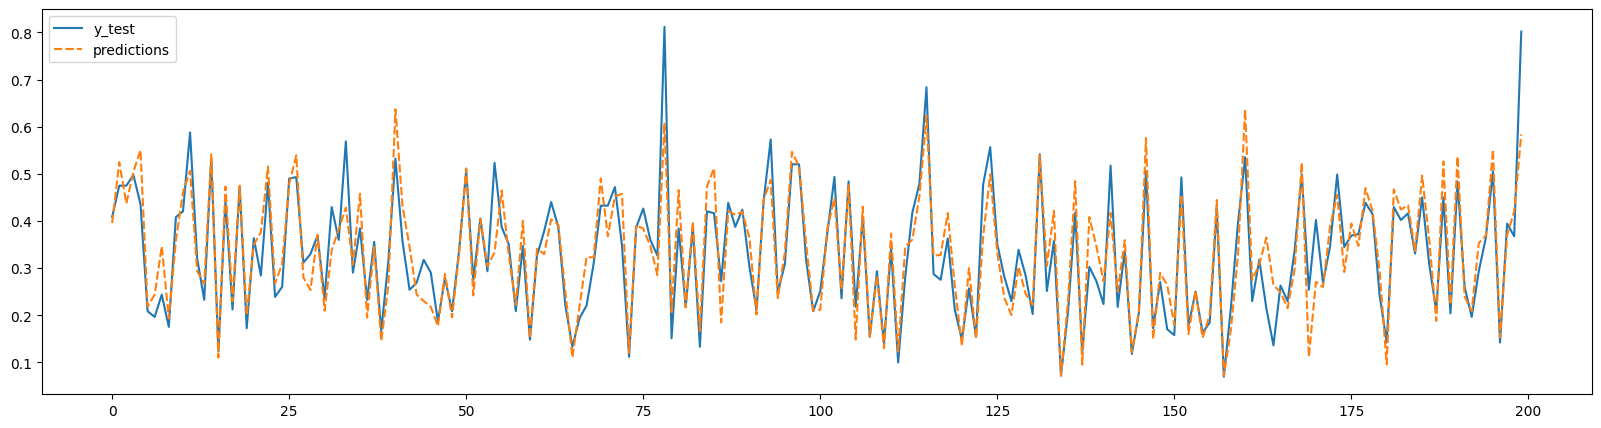

In [ ]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:200, :])
plt.show()

#Tuning 

In [ ]:
def build(hp):
        model = keras.Sequential()
        
        hp_units_1= hp.Int('units_1', min_value=32, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse'])

        return model

In [ ]:
MAX_TRIALS = 20
tuner= RandomSearch(build,
               objective = 'val_mse',
               max_trials = MAX_TRIALS,
               seed = seed,
               directory = 'random_search',
               project_name = 'project',
               overwrite = True)

In [ ]:
print('searching for the best params!')

tuner.search(x = X_train,
             y = y_train,
             epochs = 100,
             batch_size = 64,
             validation_data = (X_val, y_val),
             verbose = 0,
             callbacks= []
            )

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = tuner.get_best_models(num_models = 1)[0]

searching for the best params!


In [ ]:
print(f"""The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')}  

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 64 
third layer is 48  

and the optimal learning rate for the optimizer
is 0.0006752863927347823.



In [ ]:
tuned_model = tuner.hypermodel.build(best_hps)

history_tuned = tuned_model.fit(X_train, y_train, 
          epochs = 200, 
          validation_data = (X_val, y_val),
          verbose = 0,
          callbacks = early_stopping_cb)

Epoch 186: early stopping


In [ ]:
y_pred = tuned_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
MSE 0.002887737034876913
R2 0.8562680183435688


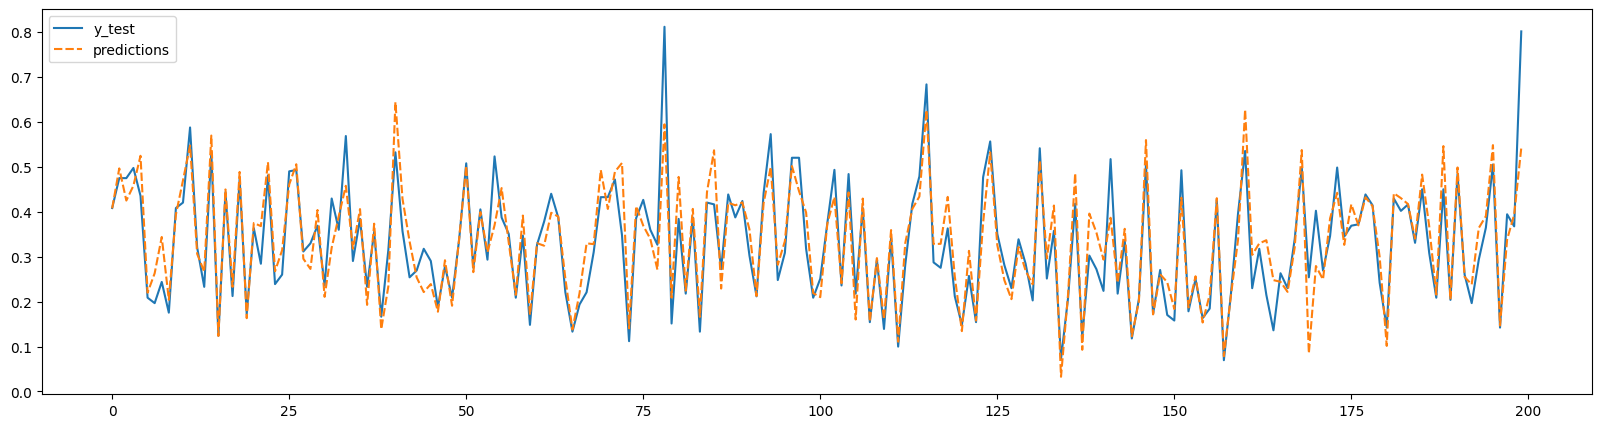

In [ ]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize = (20, 5))
sns.lineplot(data = aux.iloc[:200, :])
plt.show()

# K-fold

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow.keras.metrics as tfk

num_folds = 5
epochs = 200

mse_scores = []
mae_scores = []
rmse_scores = []

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=seed, shuffle=True)
data_k = np.concatenate((X_train, y_train), axis=1)

kf = KFold(n_splits=num_folds, shuffle=True)

for train_index, val_index in kf.split(data_k):
    
    train_data, val_data = data_k[train_index], data_k[val_index]
    
    X_train_fold, y_train_fold = train_data[:, :-1], train_data[:, -1]
    X_val_fold, y_val_fold = val_data[:, :-1], val_data[:, -1]
    
    # Select the model
    ffnn = tuned_model
    
    # Train the model
    history = ffnn.fit(
        X_train_fold, y_train_fold,
        epochs = epochs,
        validation_data = (X_val_fold, y_val_fold),
        callbacks = early_stopping_cb,
        verbose = 0
    )
    
    # Compute the evaluation metrics on the current fold
    mse, mae, rmse = ffnn.evaluate(X_val_fold, y_val_fold, verbose = 0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

# Compute the mean of the evaluation metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)

print("Mean Squared Error (MSE):", avg_mse)
print("Mean Absolute Error (MAE):", avg_mae)
print("Root Mean Squared Error (RMSE):", avg_rmse)

Epoch 71: early stopping
Epoch 24: early stopping
Epoch 22: early stopping
Epoch 24: early stopping
Epoch 28: early stopping
Mean Squared Error (MSE): 0.002063354873098433
Mean Absolute Error (MAE): 0.033094503730535504
Root Mean Squared Error (RMSE): 0.002063354873098433


In [ ]:
y_pred = ffnn.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 3ms/step
MSE 0.002879079119931201
R2 0.856698950681635


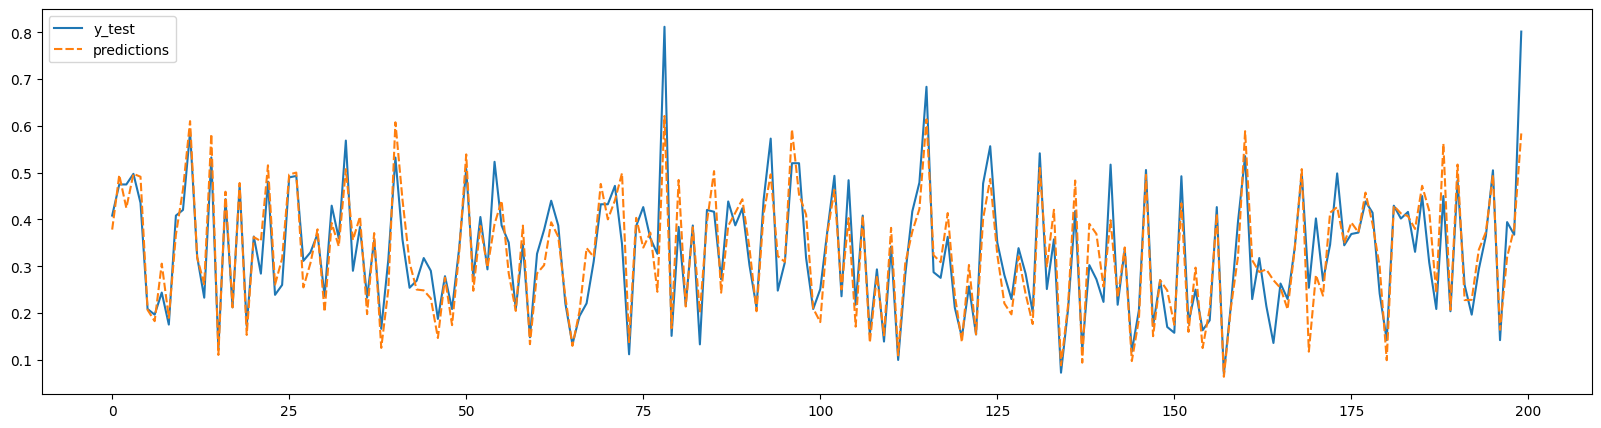

In [ ]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:200, :])
plt.show()